# drosophila_simulation_T1_analysis

> Time traces of tension and length over T1s for revision

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.config import config

jax.default_device(jax.devices('cpu')[0])
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_platform_name", "cpu")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
I0000 00:00:1712138093.065581  348699 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [ ]:
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.phase_analysis as ana

In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from scipy import optimize, ndimage

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
import importlib

In [ ]:
from joblib import Parallel, delayed

In [ ]:
importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso); importlib.reload(drs)

## Load the relevant data

In [ ]:
plot_dir = "/home/nikolas/Documents/UCSB/streichan/fridtjof paper/convergent extension physics/revision figures"

In [ ]:
base_dir = '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/runs/for_revision'
save_dir_control = f'{base_dir}/T1_time_trace_control/orientation_orthogonal_kRelax_2_kPassive_6_noiseGaussian_0.1_feedback_perimeter_noiseDynamic_0_voronoi_False_cutoff_0.3_randomSeed_1' # 1 is longest
save_dir_sat = f'{base_dir}/T1_time_trace_saturating/orientation_orthogonal_TPlus_1.2_randomSeed_1' # 1 is longest

t_final = 400

load_mesh = lambda i: iso.CellHalfEdgeMesh.load_mesh(f'{save_dir_control}/{str(i).zfill(4)}_mesh')
meshes_control= Parallel(n_jobs=6)(delayed(load_mesh)(i) for i in range(0, t_final, 1))

load_mesh = lambda i: iso.CellHalfEdgeMesh.load_mesh(f'{save_dir_sat}/{str(i).zfill(4)}_mesh')
meshes_sat= Parallel(n_jobs=6)(delayed(load_mesh)(i) for i in range(0, t_final, 1))

In [ ]:
with open(f"{save_dir_control}/property_dict.pickle", "rb") as f:
    property_dict_control = pickle.load(f)
with open(f"{save_dir_control}/last_flipped_edges.pickle", "rb") as f:
    last_flipped_edges_control = pickle.load(f)

with open(f"{save_dir_sat}/property_dict.pickle", "rb") as f:
    property_dict_sat = pickle.load(f)
with open(f"{save_dir_sat}/last_flipped_edges.pickle", "rb") as f:
    last_flipped_edges_sat = pickle.load(f)

In [ ]:
length_dicts_control = [x.get_primal_edge_lens(include_duplicates=True) for x in tqdm(meshes_control)]
length_dicts_sat = [x.get_primal_edge_lens(include_duplicates=True) for x in tqdm(meshes_sat)]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
tension_dicts_control = [x.get_rel_tension() for x in tqdm(meshes_control)]
tension_dicts_sat = [x.get_rel_tension() for x in tqdm(meshes_sat)]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
lengths_stacked_control = []
lengths_stacked_sat = []

t0 = 80
t1 = 300

dt = 75

for i in range(t0, t1):
    for e in last_flipped_edges_control[i]:
        if not e in property_dict_control['passive_edges']:
            length = np.stack([x[e] for x in length_dicts_control])
            lengths_stacked_control.append(length[i-dt:i+dt])
lengths_stacked_control = np.stack(lengths_stacked_control)

for i in range(t0, t1):
    for e in last_flipped_edges_sat[i]:
        if not e in property_dict_sat['passive_edges']:
            length = np.stack([x[e] for x in length_dicts_sat])
            lengths_stacked_sat.append(length[i-dt:i+dt])
lengths_stacked_sat = np.stack(lengths_stacked_sat)

In [ ]:
tensions_stacked_control

[]

In [ ]:
tensions_stacked_control = []
tensions_stacked_sat = []

for i in range(t0, t1):
    for e in last_flipped_edges_control[i]:
        if not e in property_dict_control['passive_edges']:
            tensions = np.stack([x[e] for x in tension_dicts_control])
            tensions_stacked_control.append(tensions[i-dt:i+dt])
tensions_stacked_control = np.stack(tensions_stacked_control)

for i in range(t0, t1):
    for e in last_flipped_edges_sat[i]:
        if not e in property_dict_sat['passive_edges']:
            #e = meshes_control[i].hes[e].twin._heid
            tensions = np.stack([x[e] for x in tension_dicts_sat])
            tensions_stacked_sat.append(tensions[i-dt:i+dt])
tensions_stacked_sat = np.stack(tensions_stacked_sat)

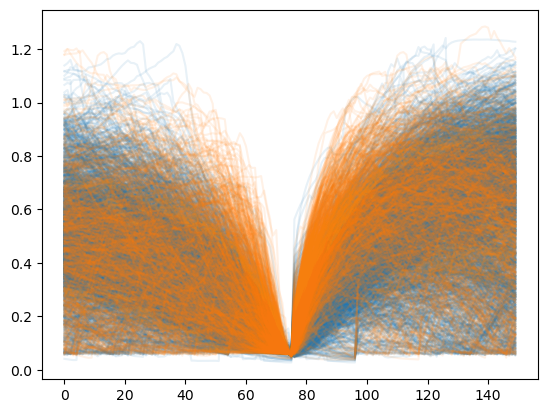

In [ ]:
for x in lengths_stacked_control:
    plt.plot(x, color="tab:blue", alpha=0.1)
    
for x in lengths_stacked_sat:
    plt.plot(x, color="tab:orange", alpha=0.1)

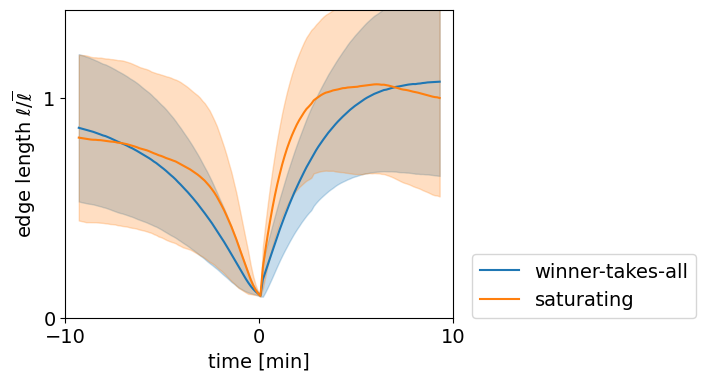

In [ ]:
fig = plt.figure(figsize=(5,4))

length_scale_control = np.array([np.mean(list(x.values())) for x in length_dicts_control])[t0-dt:t0+dt]
length_scale_sat = np.array([np.mean(list(x.values())) for x in length_dicts_sat])[t0-dt:t0+dt]

time_T1 = np.arange(lengths_stacked_control.shape[1]) * 0.005 * 25
time_T1 -= time_T1.mean()

mean_control = (lengths_stacked_control.mean(axis=0)) / length_scale_control
std_control = lengths_stacked_control.std(axis=0) / length_scale_control

mean_sat = (lengths_stacked_sat.mean(axis=0)) / length_scale_sat
std_sat = lengths_stacked_sat.std(axis=0) / length_scale_sat

plt.plot(time_T1, mean_control, color='tab:blue', label='winner-takes-all')
plt.fill_between(time_T1, mean_control-std_control, mean_control+std_control, color='tab:blue', alpha=.25)

plt.plot(time_T1, mean_sat, color='tab:orange', label='saturating')
plt.fill_between(time_T1, mean_sat-std_sat, mean_sat+std_sat, color='tab:orange', alpha=.25)

plt.xlim([-8, 8])
plt.xticks([-10, 0, 10], fontsize=14)
plt.yticks([0, 1], fontsize=14)
plt.ylim([0, 1.4])

plt.xlabel('time [min]', fontsize=14)
plt.ylabel(r'edge length $\ell/\overline{\ell}$', fontsize=14)
plt.legend(fontsize=14, loc=(1.05, 0))

plt.savefig(f"{plot_dir}/length_T1.pdf")

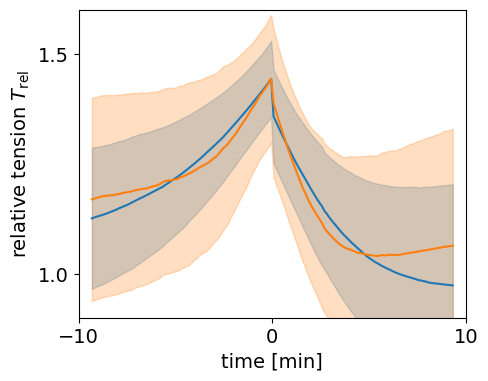

In [ ]:
fig = plt.figure(figsize=(5,4))

time_T1 = np.arange(lengths_stacked_control.shape[1]) * 0.005 * 25
time_T1 -= time_T1.mean()

mean_control = (tensions_stacked_control.mean(axis=0))
std_control = tensions_stacked_control.std(axis=0)

mean_sat = (tensions_stacked_sat.mean(axis=0))
std_sat = tensions_stacked_sat.std(axis=0)

plt.plot(time_T1, mean_control, color='tab:blue', label='winner-takes-all')
plt.fill_between(time_T1, mean_control-std_control, mean_control+std_control, color='tab:blue', alpha=.25)

plt.plot(time_T1, mean_sat, color='tab:orange', label='saturating')
plt.fill_between(time_T1, mean_sat-std_sat, mean_sat+std_sat, color='tab:orange', alpha=.25)

plt.xlim([-8, 8])
plt.xticks([-10, 0, 10], fontsize=14)
plt.yticks([1, 1.5], fontsize=14)
plt.ylim([0.9, 1.6])

plt.xlabel('time [min]', fontsize=14)
plt.ylabel(r'relative tension $T_\text{rel}$', fontsize=14)
#plt.legend(fontsize=14, loc="upper left")

plt.savefig(f"{plot_dir}/T_rel_T1.pdf")

In [ ]:
pl